In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
spark

In [4]:
sc.stop()

In [5]:
spark.stop()

In [6]:
config = SparkConf().setMaster('local[4]').setAppName("Assignment8")
sc = SparkContext(conf = config)

In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Assignment8").getOrCreate()
spark

In [8]:
churn_data = spark.read.csv("file:///home/hadoop/Downloads/Telco_Customer_Churn.csv",inferSchema=True,header=True)

In [9]:
churn_data.createOrReplaceTempView('churndata')

### a) Analyze how customer retention varies based on how long the customer has stayed with the company (tenure).

In [10]:
result = spark.sql('''
select 
    tenure,
    count(*) AS TotalCustomers,
    sum(case when Churn = 'No' then 1 else 0 end) as RetainedCustomers,
    sum(case when Churn = 'No' then 1 else 0 end) * 100 / count(*) AS RetentionRate
from 
    churndata
where tenure>0
group by tenure
order by tenure

''')
result.show()

+------+--------------+-----------------+------------------+
|tenure|TotalCustomers|RetainedCustomers|     RetentionRate|
+------+--------------+-----------------+------------------+
|     1|           613|              233| 38.00978792822186|
|     2|           238|              115|48.319327731092436|
|     3|           200|              106|              53.0|
|     4|           176|               93| 52.84090909090909|
|     5|           133|               69|  51.8796992481203|
|     6|           110|               70| 63.63636363636363|
|     7|           131|               80| 61.06870229007634|
|     8|           123|               81| 65.85365853658537|
|     9|           119|               73| 61.34453781512605|
|    10|           116|               71|61.206896551724135|
|    11|            99|               68| 68.68686868686869|
|    12|           117|               79| 67.52136752136752|
|    13|           109|               71| 65.13761467889908|
|    14|            76| 

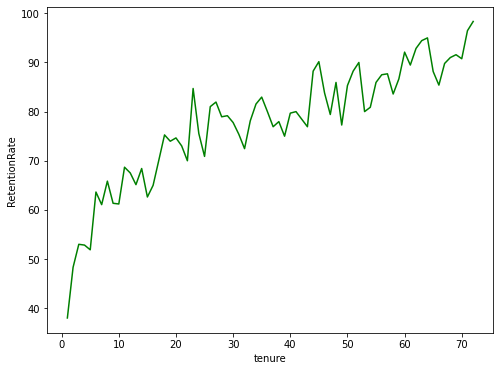

In [11]:
result_pd = result.toPandas()
plt.figure(figsize=(8,6))
sns.lineplot(x="tenure",y="RetentionRate",data = result_pd,color ='green')
plt.show()

### b) Investigate the churn rate of customers who subscribe to streaming services like StreamingTV and StreamingMovies.

In [12]:
spark.sql("""
SELECT
    COUNT(*) AS total_customers,
    SUM(CASE WHEN churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    (SUM(CASE WHEN churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS churn_rate
FROM
    churndata
WHERE
    StreamingTV = 'Yes' AND StreamingMovies = 'Yes'
""").show()

+---------------+-----------------+-----------------+
|total_customers|churned_customers|       churn_rate|
+---------------+-----------------+-----------------+
|           1940|              571|29.43298969072165|
+---------------+-----------------+-----------------+



### c) Write Spark SQL to group customers by their tenure (e.g., 0-12 months, 13-24 months, etc.) and analyze churn rates in these tenure groups.

In [13]:
result = spark.sql('''
select 
    case 
        when tenure >=0 and tenure<=12 then "0-12 months"
        when tenure >=13 and tenure<=24 then "13-24 months"
        when tenure >=25 and tenure<=36 then "25-36 months"
        when tenure >=37 and tenure<=48 then "37-48 months"
        when tenure >=49 and tenure<=60 then "49-60 months"
        else "61-72 months"
    end as tenure_group,
count(*) as customers,
sum(case when Churn = 'Yes' then 1 else 0 end) as churned_customers,
sum(case when Churn = 'Yes' then 1 else 0 end)/count(*)*100 as churn_rate
from churndata
group by tenure_group
order by tenure_group
''')
result.show()

+------------+---------+-----------------+------------------+
|tenure_group|customers|churned_customers|        churn_rate|
+------------+---------+-----------------+------------------+
| 0-12 months|     2186|             1037|47.438243366880144|
|13-24 months|     1024|              294|        28.7109375|
|25-36 months|      832|              180|21.634615384615387|
|37-48 months|      762|              145|19.028871391076116|
|49-60 months|      832|              120|14.423076923076922|
|61-72 months|     1407|               93| 6.609808102345416|
+------------+---------+-----------------+------------------+



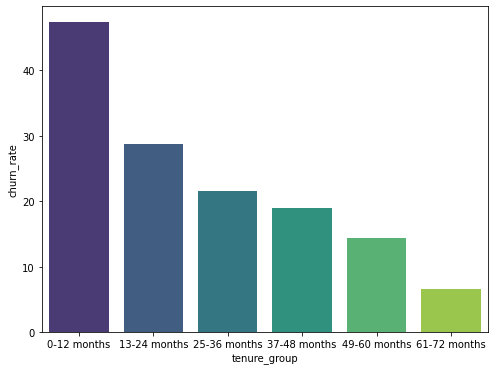

In [14]:
result_pd = result.toPandas()
plt.figure(figsize=(8,6))
sns.barplot(x="tenure_group",y="churn_rate",data = result_pd,palette="viridis")
plt.show()

### d)Analyze the impact of contract types and payment methods on churn rates.

In [15]:
result = spark.sql('''
select
    Contract,
    PaymentMethod,
    count(*) as customers,
    sum(case when Churn = 'Yes' then 1 else 0 end) as churned_customers,
    sum(case when Churn = 'Yes'then 1 else 0 end)/count(*) *100 as churn_rate
from churndata
group by Contract,PaymentMethod
order by Contract,PaymentMethod
''')
result.show()

+--------------+--------------------+---------+-----------------+------------------+
|      Contract|       PaymentMethod|customers|churned_customers|        churn_rate|
+--------------+--------------------+---------+-----------------+------------------+
|Month-to-month|Bank transfer (au...|      589|              201|34.125636672325975|
|Month-to-month|Credit card (auto...|      543|              178| 32.78084714548803|
|Month-to-month|    Electronic check|     1850|              994|53.729729729729726|
|Month-to-month|        Mailed check|      893|              282| 31.57894736842105|
|      One year|Bank transfer (au...|      391|               38| 9.718670076726342|
|      One year|Credit card (auto...|      398|               41|10.301507537688442|
|      One year|    Electronic check|      347|               64|18.443804034582133|
|      One year|        Mailed check|      337|               23| 6.824925816023739|
|      Two year|Bank transfer (au...|      564|               19|

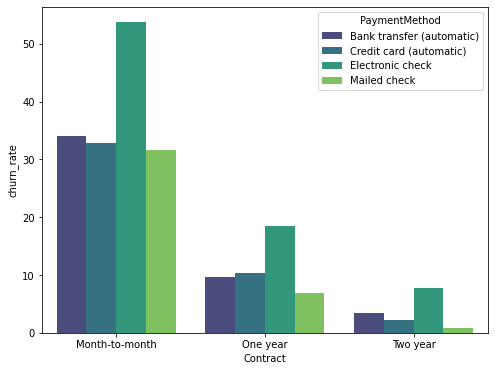

In [16]:
result_pd = result.toPandas()
plt.figure(figsize=(8,6))
sns.barplot(x="Contract",y="churn_rate",data = result_pd,hue = "PaymentMethod",palette="viridis")
plt.show()

### e)Explore the distribution of monthly charges for customers based on their type of internet service.

In [17]:
result = spark.sql('''
select InternetService,count(*) as customers,avg(MonthlyCharges) as Average_Charge,
min(MonthlyCharges) as Min_charge,max(MonthlyCharges) as max_charge
from churndata
group by InternetService
''')
result.show()

+---------------+---------+------------------+----------+----------+
|InternetService|customers|    Average_Charge|Min_charge|max_charge|
+---------------+---------+------------------+----------+----------+
|    Fiber optic|     3096| 91.50012919896615|     67.75|    118.75|
|             No|     1526|21.079193971166454|     18.25|      26.9|
|            DSL|     2421| 58.10216852540261|     23.45|      94.8|
+---------------+---------+------------------+----------+----------+



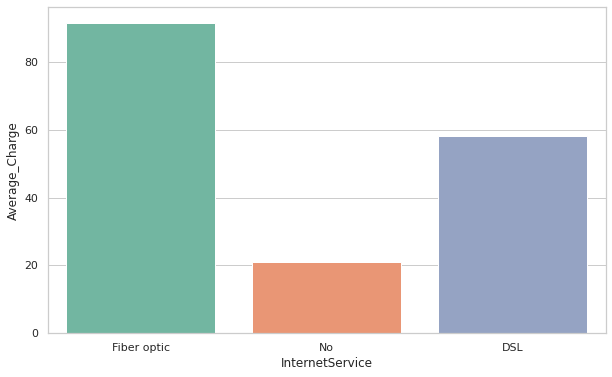

In [18]:
result_df = result.toPandas()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(
    x='InternetService',
    y='Average_Charge',
    data=result_df,
    palette='Set2'
)
plt.show()

### f) Identify the top 10 customers who have contributed the most revenue to the company, based on total charges.

In [19]:
result = spark.sql('''
select customerID,float(TotalCharges)
from churndata
order by float(TotalCharges) desc
limit 10
''')
result.show()

+----------+------------+
|customerID|TotalCharges|
+----------+------------+
|2889-FPWRM|      8684.8|
|7569-NMZYQ|     8672.45|
|9739-JLPQJ|      8670.1|
|9788-HNGUT|      8594.4|
|8879-XUAHX|     8564.75|
|9924-JPRMC|     8547.15|
|0675-NCDYU|     8543.25|
|6650-BWFRT|      8529.5|
|0164-APGRB|      8496.7|
|1488-PBLJN|      8477.7|
+----------+------------+



### g) Calculate the churn rate segmented by gender and whether the customer is a senior citizen.

In [20]:
result = spark.sql('''
select
    gender,
    SeniorCitizen,
    count(*) as customers,
    sum(case when Churn ='Yes' then 1 else 0 end) as churned_cust,
    sum(case when Churn ='Yes' then 1 else 0 end)/count(*) * 100 as churn_rate
from churndata
group by gender,SeniorCitizen
order by gender,SeniorCitizen
''')
result.show()

+------+-------------+---------+------------+------------------+
|gender|SeniorCitizen|customers|churned_cust|        churn_rate|
+------+-------------+---------+------------+------------------+
|Female|            0|     2920|         699|23.938356164383563|
|Female|            1|      568|         240| 42.25352112676056|
|  Male|            0|     2981|         694|23.280778262328077|
|  Male|            1|      574|         236| 41.11498257839721|
+------+-------------+---------+------------+------------------+



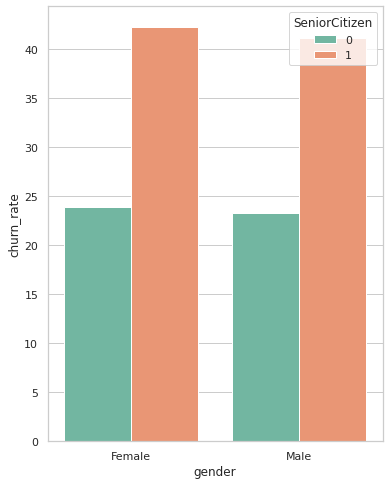

In [21]:
result_pd = result.toPandas()
plt.figure(figsize=(6, 8))
sns.barplot(
    x='gender',
    y='churn_rate',
    hue='SeniorCitizen',
    data=result_pd,
    palette='Set2'
)
plt.show()

### h) Write query to calculate Correlation between dependents and churn. Explore whether having dependents affects customer churn rates.

In [22]:
result = spark.sql('''
select
    Dependents,
    count(*) as customers,
    sum(case when Churn ='Yes' then 1 else 0 end) as churned_cust,
    sum(case when Churn ='Yes' then 1 else 0 end)/count(*) * 100 as churn_rate
from churndata
group by Dependents

''')
result.show()

+----------+---------+------------+------------------+
|Dependents|customers|churned_cust|        churn_rate|
+----------+---------+------------+------------------+
|        No|     4933|        1543|31.279140482465028|
|       Yes|     2110|         326|15.450236966824646|
+----------+---------+------------+------------------+



### i) Predict potential churn rates by analyzing the relationship between monthly charges, contract types, and the churn rate.

In [23]:
result = spark.sql('''
select
    Contract,
    sum(MonthlyCharges) as TotalMonthlyCharges,
    count(*) as customers,
    sum(case when Churn ='Yes' then 1 else 0 end) as churned_cust,
    sum(case when Churn ='Yes' then 1 else 0 end)/count(*) * 100 as churn_rate
from churndata
group by Contract

''')
result.show()

+--------------+-------------------+---------+------------+------------------+
|      Contract|TotalMonthlyCharges|customers|churned_cust|        churn_rate|
+--------------+-------------------+---------+------------+------------------+
|Month-to-month| 257294.14999999892|     3875|        1655| 42.70967741935484|
|      One year|  95816.59999999986|     1473|         166|11.269517990495586|
|      Two year| 103005.84999999995|     1695|          48| 2.831858407079646|
+--------------+-------------------+---------+------------+------------------+



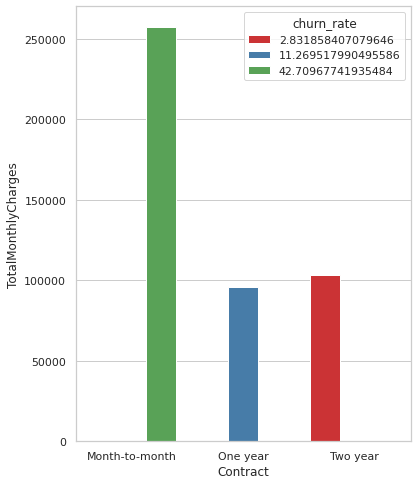

In [24]:
result_pd = result.toPandas()
plt.figure(figsize=(6, 8))
sns.barplot(
    x='Contract',
    y='TotalMonthlyCharges',
    hue='churn_rate',
    data=result_pd,
    palette='Set1'
)
plt.show()

### j) Determine the churn rate for customers who have multiple services (Phone, Internet, and Streaming), which can help understand whether bundling services leads to higher or lower churn. Calculate churn rate for customers with multiple services.

In [25]:
result = spark.sql('''
select
    count(*) as customers,
    sum(case when Churn ='Yes' then 1 else 0 end) as churned_cust,
    sum(case when Churn ='Yes' then 1 else 0 end)/count(*) * 100 as churn_rate
from churndata
where PhoneService = "Yes"
      and InternetService in ("Fiber optic","DSL")
      and (StreamingTV ="Yes" or StreamingMovies ="Yes")
''')
result.show()

+---------+------------+------------------+
|customers|churned_cust|        churn_rate|
+---------+------------+------------------+
|     3116|         968|31.065468549422338|
+---------+------------+------------------+



### k) Churn Impact by device protection and online backup services. Write query to investigate whether having device protection or online backup services affects churn rates.

In [42]:
result = spark.sql('''
select
    count(*) as customers,
    sum(case when Churn ='Yes' then 1 else 0 end) as churned_cust,
    sum(case when Churn ='Yes' then 1 else 0 end)/count(*) * 100 as churn_rate
from churndata
where DeviceProtection = "Yes"
      and OnlineBackup = "Yes"    
''')
result.show()

+---------+------------+----------------+
|customers|churned_cust|      churn_rate|
+---------+------------+----------------+
|     1318|         223|16.9195751138088|
+---------+------------+----------------+



### l) Explore churn rates among customers who do not have phone service and investigate if it influences customer retention.

In [27]:
result = spark.sql('''
select
    count(*) as customers,
    sum(case when Churn ='Yes' then 1 else 0 end) as churned_cust,
    sum(case when Churn ='Yes' then 1 else 0 end)/count(*) * 100 as churn_rate
from churndata
where PhoneService = "No"    
''')
result.show()

+---------+------------+------------------+
|customers|churned_cust|        churn_rate|
+---------+------------+------------------+
|      682|         170|24.926686217008797|
+---------+------------+------------------+



### m) Understand the relationship between payment methods and contract types on customer churn. This query will help you discover which combinations are most prone to churn.

In [28]:
result = spark.sql('''
select
    PaymentMethod,
    Contract,
    count(*) as customers,
    sum(case when Churn ='Yes' then 1 else 0 end) as churned_cust,
    sum(case when Churn ='Yes' then 1 else 0 end)/count(*) * 100 as churn_rate
from churndata
group by PaymentMethod,Contract
order by churn_rate desc
''')
result.show()

+--------------------+--------------+---------+------------+------------------+
|       PaymentMethod|      Contract|customers|churned_cust|        churn_rate|
+--------------------+--------------+---------+------------+------------------+
|    Electronic check|Month-to-month|     1850|         994|53.729729729729726|
|Bank transfer (au...|Month-to-month|      589|         201|34.125636672325975|
|Credit card (auto...|Month-to-month|      543|         178| 32.78084714548803|
|        Mailed check|Month-to-month|      893|         282| 31.57894736842105|
|    Electronic check|      One year|      347|          64|18.443804034582133|
|Credit card (auto...|      One year|      398|          41|10.301507537688442|
|Bank transfer (au...|      One year|      391|          38| 9.718670076726342|
|    Electronic check|      Two year|      168|          13| 7.738095238095238|
|        Mailed check|      One year|      337|          23| 6.824925816023739|
|Bank transfer (au...|      Two year|   

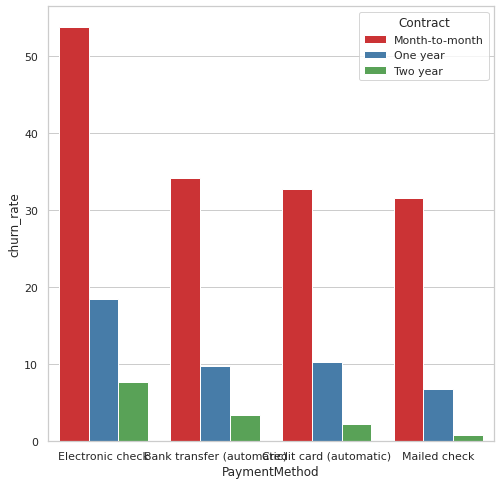

In [29]:
result_pd = result.toPandas()
plt.figure(figsize=(8, 8))
sns.barplot(
    x='PaymentMethod',
    y='churn_rate',
    hue='Contract',
    data=result_pd,
    palette='Set1'
)
plt.show()

### n) Analyze how customer churn is affected by senior citizen status and whether the customer has dependents.

In [30]:
result = spark.sql('''
select
    Dependents,
    SeniorCitizen,
    count(*) as customers,
    sum(case when Churn ='Yes' then 1 else 0 end) as churned_cust,
    sum(case when Churn ='Yes' then 1 else 0 end)/count(*) * 100 as churn_rate
from churndata
group by Dependents,SeniorCitizen
order by churn_rate desc
''')
result.show()

+----------+-------------+---------+------------+------------------+
|Dependents|SeniorCitizen|customers|churned_cust|        churn_rate|
+----------+-------------+---------+------------+------------------+
|        No|            1|     1051|         454| 43.19695528068506|
|        No|            0|     3882|        1089|28.052550231839255|
|       Yes|            1|       91|          22|24.175824175824175|
|       Yes|            0|     2019|         304|15.056958890539871|
+----------+-------------+---------+------------+------------------+



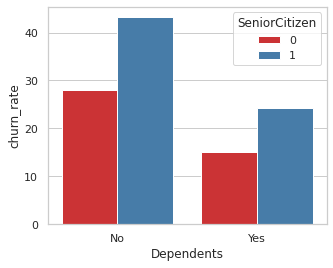

In [31]:
result_pd = result.toPandas()
plt.figure(figsize=(5, 4))
sns.barplot(
    x='Dependents',
    y='churn_rate',
    hue='SeniorCitizen',
    data=result_pd,
    palette='Set1'
)
plt.show()

### o)Explore whether subscribing to streaming services like Streaming TV and Streaming Movies influences the churn rate.

In [32]:
result = spark.sql('''
select
    StreamingTV,
    StreamingMovies,
    count(*) as customers,
    sum(case when Churn ='Yes' then 1 else 0 end) as churned_cust,
    sum(case when Churn ='Yes' then 1 else 0 end)/count(*) * 100 as churn_rate
from churndata
group by StreamingTV,StreamingMovies
order by churn_rate desc
''')
result.show()

+-------------------+-------------------+---------+------------+------------------+
|        StreamingTV|    StreamingMovies|customers|churned_cust|        churn_rate|
+-------------------+-------------------+---------+------------+------------------+
|                 No|                 No|     2018|         695|  34.4400396432111|
|                Yes|                 No|      767|         243|31.681877444589308|
|                 No|                Yes|      792|         247|31.186868686868685|
|                Yes|                Yes|     1940|         571| 29.43298969072165|
|No internet service|No internet service|     1526|         113| 7.404980340760157|
+-------------------+-------------------+---------+------------+------------------+



### p) Understand how tenure and MonthlyCharges differ between churned and non-churned customers. This can provide insights into the behavior of long-term customers.

In [33]:
result = spark.sql('''
select 
    case when tenure <12 then "New Customers"
    else "Long Term Customers"
    end as CustomerType,
    count(*) as customers,
    sum(case when Churn ='Yes' then 1 else 0 end) as churned_cust,
    sum(case when Churn ='Yes' then 1 else 0 end)/count(*) * 100 as churn_rate
from churndata
group by CustomerType
''')
result.show()

+-------------------+---------+------------+------------------+
|       CustomerType|customers|churned_cust|        churn_rate|
+-------------------+---------+------------+------------------+
|      New Customers|     2069|         999| 48.28419526341228|
|Long Term Customers|     4974|         870|17.490952955367913|
+-------------------+---------+------------+------------------+



New customers exhibit a much higher churn rate (48.28%) compared to long-term customers (17.49%). This indicates that newer customers are more likely to leave, suggesting potential issues with initial customer satisfaction or onboarding.

### q) Compare monthly charges and churn rates between newer customers and long-time customers.

In [34]:
result = spark.sql('''
SELECT 
    CASE 
        WHEN tenure <= 12 THEN 'New' 
        ELSE 'Long Term' 
    END AS CustomerCategory,
    AVG(MonthlyCharges) AS AvgMonthlyCharges,
    COUNT(*) AS TotalCustomers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS ChurnedCustomers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 / COUNT(*) AS ChurnRate
FROM 
    churndata
GROUP BY 
    CustomerCategory
ORDER BY 
    CustomerCategory

''')
result.show()

+----------------+-----------------+--------------+----------------+------------------+
|CustomerCategory|AvgMonthlyCharges|TotalCustomers|ChurnedCustomers|         ChurnRate|
+----------------+-----------------+--------------+----------------+------------------+
|       Long Term|68.66107679637616|          4857|             832| 17.12991558575252|
|             New|56.09778133577306|          2186|            1037|47.438243366880144|
+----------------+-----------------+--------------+----------------+------------------+



### r) What is the correlation between senior citizen status and churn rate?

In [35]:
result = spark.sql('''
select corr(SeniorCitizen, Case when Churn ='Yes' then 1 else 0 end) as Correlation
from churndata
''')
result.show()

+-------------------+
|        Correlation|
+-------------------+
|0.15088932817647233|
+-------------------+



### s) Partition customers based on whether they are senior citizens and divide them into 5 groups based on tenure. [Use NTILE.]

In [36]:
result = spark.sql('''
SELECT 
    customerID,
    tenure,
    SeniorCitizen,
    NTILE(5) OVER (PARTITION BY SeniorCitizen ORDER BY tenure) AS TenureGroup
FROM 
    churndata
''')

result.show()

+----------+------+-------------+-----------+
|customerID|tenure|SeniorCitizen|TenureGroup|
+----------+------+-------------+-----------+
|8779-QRDMV|     1|            1|          1|
|3413-BMNZE|     1|            1|          1|
|2424-WVHPL|     1|            1|          1|
|0390-DCFDQ|     1|            1|          1|
|9514-JDSKI|     1|            1|          1|
|0021-IKXGC|     1|            1|          1|
|5564-NEMQO|     1|            1|          1|
|5192-EBGOV|     1|            1|          1|
|6513-EECDB|     1|            1|          1|
|7206-GZCDC|     1|            1|          1|
|1768-ZAIFU|     1|            1|          1|
|6567-HOOPW|     1|            1|          1|
|5240-IJOQT|     1|            1|          1|
|0661-XEYAN|     1|            1|          1|
|3068-OMWZA|     1|            1|          1|
|8580-AECUZ|     1|            1|          1|
|5047-LHVLY|     1|            1|          1|
|8375-DKEBR|     1|            1|          1|
|8080-DDEMJ|     1|            1| 

### t)Use PERCENT_RANK to identify the top 5% of customers by MonthlyCharges.

In [45]:
result = spark.sql('''
SELECT 
    *
FROM (
    SELECT 
        customerID,
        MonthlyCharges,
        PERCENT_RANK() OVER (ORDER BY MonthlyCharges desc) AS PercentRank
    FROM 
        churndata
) AS RankedCustomers
WHERE 
    PercentRank <= 0.05

''')
result.show()


+----------+--------------+--------------------+
|customerID|MonthlyCharges|         PercentRank|
+----------+--------------+--------------------+
|7569-NMZYQ|        118.75|                 0.0|
|8984-HPEMB|        118.65|1.420051121840386...|
|5989-AXPUC|         118.6|2.840102243680772...|
|5734-EJKXG|         118.6|2.840102243680772...|
|8199-ZLLSA|        118.35|5.680204487361545E-4|
|9924-JPRMC|         118.2|7.100255609201931E-4|
|2889-FPWRM|         117.8|8.520306731042318E-4|
|3810-DVDQQ|         117.6|9.940357852882703E-4|
|9739-JLPQJ|         117.5|0.001136040897472309|
|2302-ANTDP|        117.45|0.001278046009656...|
|6904-JLBGY|        117.35|0.001420051121840...|
|4282-MSACW|         117.2|0.001562056234024...|
|6650-BWFRT|        117.15|0.001704061346208...|
|9788-HNGUT|        116.95|0.001846066458392502|
|1488-PBLJN|        116.85|0.001988071570576...|
|0017-IUDMW|         116.8|0.002130076682760...|
|8628-MFKAX|        116.75|0.002272081794944618|
|3680-CTHUH|        

### u) Find customers who fall within the top 5% of the distribution based on monthly charges. Compare total charges with the next customer in the same internet service type, based on monthly charges.

In [38]:
result = spark.sql('''
SELECT CustomerID,InternetService,MonthlyCharges,TotalCharges,next_charge,
    ROUND((TotalCharges - next_charge),3) Charge_diff
    FROM (
        SELECT CustomerID,InternetService,MonthlyCharges,TotalCharges,
        PERCENT_RANK() OVER (ORDER BY MonthlyCharges DESC) AS MonthlyRank,
        LEAD(TotalCharges) OVER(PARTITION BY InternetService ORDER BY MonthlyCharges DESC) next_charge
        FROM churndata
    ) _
    WHERE MonthlyRank <= 0.05
    ORDER BY MonthlyRank
''')
result.show()

+----------+---------------+--------------+------------+-----------+-----------+
|CustomerID|InternetService|MonthlyCharges|TotalCharges|next_charge|Charge_diff|
+----------+---------------+--------------+------------+-----------+-----------+
|7569-NMZYQ|    Fiber optic|        118.75|     8672.45|     8477.6|     194.85|
|8984-HPEMB|    Fiber optic|        118.65|      8477.6|    7990.05|     487.55|
|5989-AXPUC|    Fiber optic|         118.6|     7990.05|     7365.7|     624.35|
|5734-EJKXG|    Fiber optic|         118.6|      7365.7|    7804.15|    -438.45|
|8199-ZLLSA|    Fiber optic|        118.35|     7804.15|    8547.15|     -743.0|
|9924-JPRMC|    Fiber optic|         118.2|     8547.15|     8684.8|    -137.65|
|2889-FPWRM|    Fiber optic|         117.8|      8684.8|     8308.9|      375.9|
|3810-DVDQQ|    Fiber optic|         117.6|      8308.9|     8670.1|     -361.2|
|9739-JLPQJ|    Fiber optic|         117.5|      8670.1|     5438.9|     3231.2|
|2302-ANTDP|    Fiber optic|

### v) Find the top 5 customers with the highest MonthlyCharges within each Contract type.

In [39]:
result = spark.sql('''
select *
from (
    select 
        customerID,
        MonthlyCharges,
        Contract,
        DENSE_RANK() OVER (PARTITION BY Contract ORDER BY MonthlyCharges DESC) AS Rank
    from 
        churndata
) AS RankedCustomers
where Rank<=5
''')
result.show()

+----------+--------------+--------------+----+
|customerID|MonthlyCharges|      Contract|Rank|
+----------+--------------+--------------+----+
|2302-ANTDP|        117.45|Month-to-month|   1|
|8016-NCFVO|         116.5|Month-to-month|   2|
|9659-QEQSY|        115.65|Month-to-month|   3|
|4361-BKAXE|         114.5|Month-to-month|   4|
|6710-HSJRD|         114.1|Month-to-month|   5|
|5734-EJKXG|         118.6|      One year|   1|
|8199-ZLLSA|        118.35|      One year|   2|
|2889-FPWRM|         117.8|      One year|   3|
|4282-MSACW|         117.2|      One year|   4|
|3680-CTHUH|         116.6|      One year|   5|
|7569-NMZYQ|        118.75|      Two year|   1|
|8984-HPEMB|        118.65|      Two year|   2|
|5989-AXPUC|         118.6|      Two year|   3|
|9924-JPRMC|         118.2|      Two year|   4|
|3810-DVDQQ|         117.6|      Two year|   5|
+----------+--------------+--------------+----+



### w) Calculate the churn rate in each Contract type and rank the contracts by churn rate.

In [40]:
result = spark.sql('''
select 
    Contract,
    TotalCustomers,
    ChurnedCustomers,
    ChurnRate,
    RANK() OVER (ORDER BY ChurnRate DESC) AS Rank
FROM (
    select 
        Contract,
        COUNT(*) AS TotalCustomers,
        SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS ChurnedCustomers,
        SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 / COUNT(*) AS ChurnRate
    FROM 
        churndata
    GROUP BY 
        Contract
) AS ChurnRates

''')
result.show()

+--------------+--------------+----------------+------------------+----+
|      Contract|TotalCustomers|ChurnedCustomers|         ChurnRate|Rank|
+--------------+--------------+----------------+------------------+----+
|Month-to-month|          3875|            1655| 42.70967741935484|   1|
|      One year|          1473|             166|11.269517990495586|   2|
|      Two year|          1695|              48| 2.831858407079646|   3|
+--------------+--------------+----------------+------------------+----+



### x) Perform an in-depth analysis of customers using window functions to understand customer rankings,distribution, and trends in charges and tenure.

In [41]:
result = spark.sql('''
SELECT 
    customerID,
    tenure,
    RANK() OVER (ORDER BY MonthlyCharges DESC) AS ChargeRank,
    RANK() OVER (ORDER BY tenure DESC) AS TenureRank,
    NTILE(4) OVER (ORDER BY MonthlyCharges) AS Quartile,
    SUM(MonthlyCharges) OVER (ORDER BY customerID ROWS UNBOUNDED PRECEDING) AS RunningTotal,
    CASE 
        WHEN tenure <= 12 THEN 'New Customers'
        WHEN tenure BETWEEN 13 AND 24 THEN '1-2 Years'
        ELSE 'Long Term Customers'
    END AS TenureGroup
from churndata
order by RunningTotal


''')
result.show()

+----------+------+----------+----------+--------+------------------+-------------------+
|customerID|tenure|ChargeRank|TenureRank|Quartile|      RunningTotal|        TenureGroup|
+----------+------+----------+----------+--------+------------------+-------------------+
|0002-ORFBO|     9|      3860|      5190|       2|              65.6|      New Customers|
|0003-MKNFE|     9|      4140|      5190|       2|             125.5|      New Customers|
|0004-TLHLJ|     4|      3295|      5806|       3|             199.4|      New Customers|
|0011-IGKFF|    13|      1087|      4749|       4|             297.4|          1-2 Years|
|0013-EXCHZ|     3|      2348|      5982|       3|381.29999999999995|      New Customers|
|0013-MHZWF|     9|      3686|      5190|       2|450.69999999999993|      New Customers|
|0013-SMEOE|    71|       236|       363|       4|             560.4|Long Term Customers|
|0014-BMAQU|    63|      2251|      1190|       3|            645.05|Long Term Customers|
|0015-UOCO